In [1]:
import models.sd_gru as sd_gru
import models.min_gru as min_gru
import models.transformer as trans

In [2]:
import tensorflow as tf
import numpy as np
import time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [3]:
doc='''Recurrent neural networks (RNNs) are deep learning models, typically used to solve problems with sequential input data such as time series. What are they, and how do we use them in time series forecasting?

RNNs are a type of neural network that retains a memory of what it has already processed and thus can learn from previous iterations during its training.

Probably you have done what most of us do when we hear any technical term for the first time. You have tried to understand what recurrent neural networks are by clicking on the top-listed non-ad Google search result. Then you will have found that Wikipedia’s article exhibits a high level of abstraction. It is of limited usefulness when we try to understand what RNNs are and what they are for: "A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes form a directed graph along a temporal sequence. This allows it to exhibit temporal dynamic behavior. Derived from feedforward neural networks, RNNs can use their internal state (memory) to process variable length sequences of inputs …. Recurrent neural networks are theoretically Turing complete and can run arbitrary programs to process arbitrary sequences of inputs." Say what?

Michael Phi provided an excellent, non-mathematical guide on RNNs in a previous Towards Data Science article of his: "Illustrated Guide to Recurrent Neural Networks | by Michael Phi | Towards Data Science". So did Will Koehrsen, in "Recurrent Neural Networks by Example in Python | by Will Koehrsen | Towards Data Science."

Let me summarize the basics we should understand about RNNs, in non-mathematical terms (and then I’d refer you to the additional explanations and illustrations in the two articles Michael and Will wrote in 2018).

A neural network – of which recurrent neural networks are one type, among other types such as convolutional networks – is composed of three elementary components: the input layer, the hidden layers, and the output layer. Each layer consists of so-called nodes (aka neurons).

I’ve read the following analogy for the three main types of neural networks, which are said to mimic human brain functions in specific ways. The following comparisons oversimplify, so best take them with a grain of salt.

the temporal lobe of our brain => artificial neural networks => mainly for classification and regression problems => one of the functions of the temporal lobe is long-term memory
the occipital lobe => convolutional neural networks => mainly for computer vision problems (though temporal convolutional networks, TCNs, can be applied to time series)
the frontal lobe => recurrent neural networks RNN => mainly for time series analysis, sequences, and lists – for instance, in language processing, which deals with sequences of characters, words, and sentences ordered by a grammar; or time series, which consist of temporal sequences of observations => one of the frontal lobe’s functions is short-term memory
Feed-forward neural networks (FFNNs) – such as the grandfather among neural networks, the original single-layer perceptron, developed in 1958— came before recurrent neural networks. In FFNNs, the information flows in only one direction: from the input layer, through the hidden layers, to the output layer, but never backwards in feedback loops. FFNN are often used in pattern recognition. The FFNN multiplies a matrix of weight factors with the inputs and generates the outputs from these weighted inputs. Feed-forward neural networks don’t retain a memory of the inputs they have processed. They suffer from anterograde amnesia, the inability to form new memories (similar to the protagonist in Christopher Nolan’s movie Memento – Wikipedia [this seemed a rare opportunity to mention anterograde amnesia and Memento in a data science article]).

A recurrent neural network, by contrast, retains a memory of what it has processed in its recent previous steps (we’ll come back to the "recent" qualifier in a minute). It makes recurrent connections by going through temporal feedback loops: the output of a preceding step is used as an input for the current process step. Unlike amnesiac FFNNs, this memory enables RNNs to process sequences of inputs without loosing track. The loops make it a recurrent network.'''

In [4]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts([doc])
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding/indexing
sequences = tokenizer.texts_to_sequences([doc])[0]

# Create input-output pairs for training
X_train, Y_train = [], []
seq_length = 3  # Number of words to predict the next word

for i in range(len(sequences) - seq_length):
    X_train.append(sequences[i:i+seq_length])
    Y_train.append(sequences[i+seq_length])

X_train = np.array(X_train)
Y_train = to_categorical(Y_train, num_classes=vocab_size)  # Convert output to one-hot


In [5]:
# %%capture
# === Training Standard GRU ===
start_time = time.time()
std_model,sd_loss = sd_gru.train_gru_model(X_train, Y_train, vocab_size,epochs=200,verbose=False)
std_time = time.time() - start_time
print(f"[Standard GRU] Training time: {std_time:.2f} seconds")

# === Training MinGRU ===
start_time = time.time()
min_model, embed_layer,min_loss = min_gru.train_min_gru_parallel(X_train, Y_train, vocab_size,epochs=200,verbose=False)
min_time = time.time() - start_time
print(f"[MinGRU] Training time: {min_time:.2f} seconds")


# === Training Transformer model ===
start_time = time.time()
trans_model,trans_loss = trans.train_transformer_model(X_train, Y_train, vocab_size, epochs=200, verbose=False)
trans_time = time.time() - start_time
print(f"[MinGRU] Training time: {trans_time:.2f} seconds")



[Standard GRU] Training time: 14.14 seconds
[MinGRU] Training time: 9.59 seconds


c:\Users\mshar\anaconda3\envs\python_mlops\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[MinGRU] Training time: 30.83 seconds


# Compare Scores

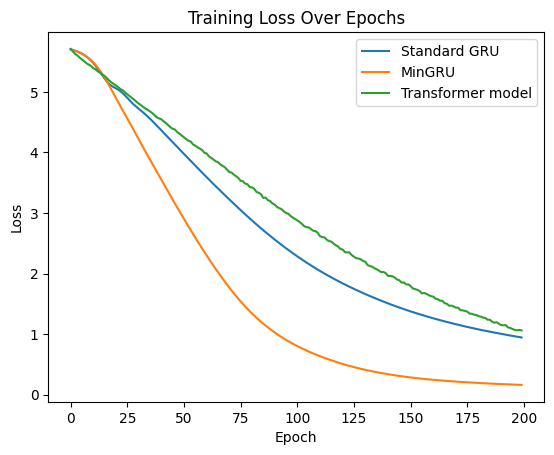

In [7]:
import matplotlib.pyplot as plt

plt.plot(sd_loss, label="Standard GRU")
plt.plot(min_loss, label="MinGRU")
plt.plot(trans_loss, label="Transformer model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()


In [8]:
print(f"Standard GRU training time: {std_time:.2f} seconds")
print(f"MinGRU training time: {min_time:.2f} seconds")
print(f"Transformer model training time: {trans_time:.2f} seconds")


Standard GRU training time: 14.14 seconds
MinGRU training time: 9.59 seconds
Transformer model training time: 30.83 seconds


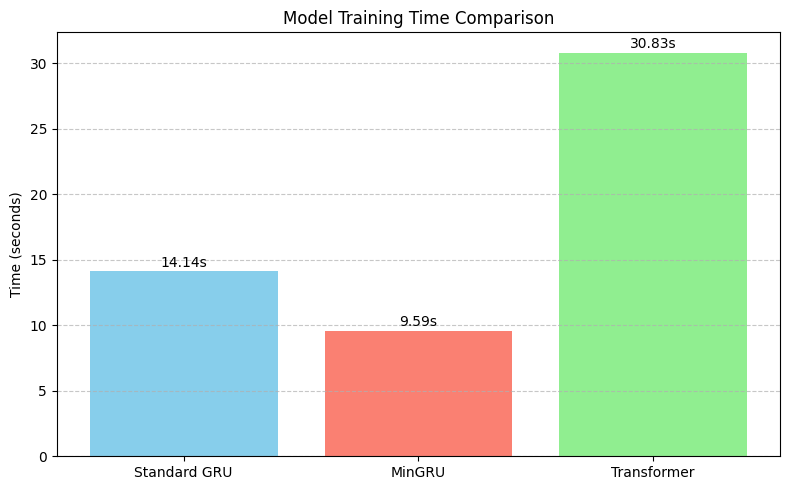

In [14]:
import matplotlib.pyplot as plt

# === Training times (make sure these variables are defined from your timing code) ===
models = ['Standard GRU', 'MinGRU', 'Transformer']
times = [std_time, min_time, trans_time]

# === Plotting ===
plt.figure(figsize=(8, 5))
bars = plt.bar(models, times, color=['skyblue', 'salmon', 'lightgreen'])

# Add time labels on top of bars
for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f'{time_val:.2f}s', ha='center', va='bottom', fontsize=10)

plt.title('Model Training Time Comparison')
plt.ylabel('Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [16]:
std_params = np.sum([np.prod(v.shape) for v in std_model.trainable_variables])
min_params = np.sum([np.prod(v.shape) for v in min_model.trainable_variables])
trans_params = np.sum([np.prod(v.shape) for v in trans_model.trainable_variables])

print(f"Standard GRU parameters: {std_params}")
print(f"MinGRU parameters: {min_params}")
print(f"Transformer model parameters: {trans_params}")


Standard GRU parameters: 6281
MinGRU parameters: 3469
Transformer model parameters: 32267


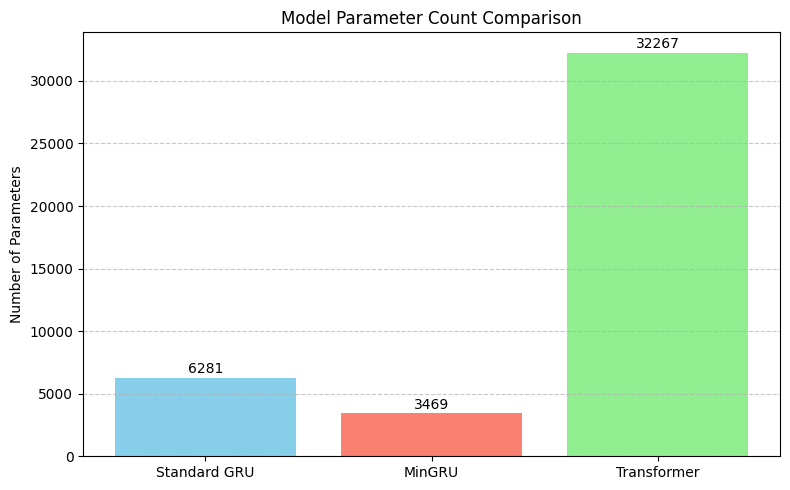

In [17]:
# === Model names and their parameter counts ===
models = ['Standard GRU', 'MinGRU', 'Transformer']
params = [std_params, min_params, trans_params]

# === Plotting ===
plt.figure(figsize=(8, 5))
bars = plt.bar(models, params, color=['skyblue', 'salmon', 'lightgreen'])

# Add value labels
for bar, param_count in zip(bars, params):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 100, f'{param_count}', ha='center', va='bottom', fontsize=10)

plt.title('Model Parameter Count Comparison')
plt.ylabel('Number of Parameters')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [20]:
test_input = "deep learning models"
print("Standard GRU prediction:", sd_gru.predict_next_word_gru(std_model, tokenizer, test_input))
print("MinGRU prediction:", min_gru.predict_min_gru_parallel(min_model, tokenizer, test_input, embed_layer, hidden_size=10))
print("Transformer model prediction:",trans.predict_next_word_transformer(trans_model, tokenizer, test_input))

Standard GRU prediction: typically
MinGRU prediction: typically
Transformer model prediction: typically


In [18]:
print("=== Next Word Predictions ===")
print(f"Input: '{test_input}'")
print(f"Standard GRU       ➜ {sd_gru.predict_next_word_gru(std_model, tokenizer, test_input)}")
print(f"MinGRU             ➜ {min_gru.predict_min_gru_parallel(min_model, tokenizer, test_input, embed_layer, hidden_size=10)}")
print(f"Transformer Model  ➜ {trans.predict_next_word_transformer(trans_model, tokenizer, test_input)}")

=== Next Word Predictions ===
Input: 'recurrent neural networks'
Standard GRU       ➜ are
MinGRU             ➜ are
Transformer Model  ➜ are


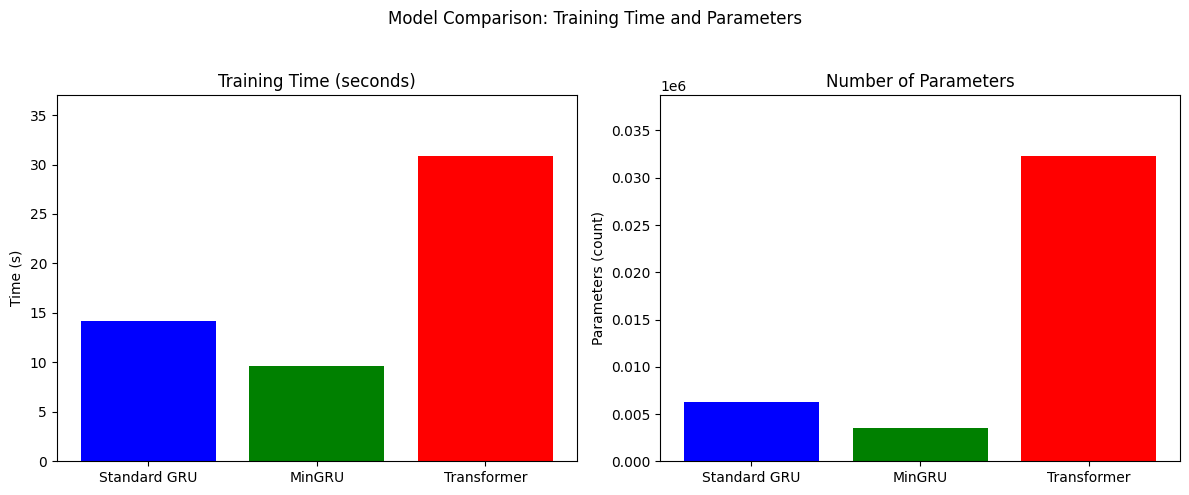

In [19]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Standard GRU', 'MinGRU', 'Transformer']
training_times = [std_time, min_time, trans_time]
param_counts = [
    np.sum([np.prod(v.shape) for v in std_model.trainable_variables]),
    np.sum([np.prod(v.shape) for v in min_model.trainable_variables]),
    np.sum([np.prod(v.shape) for v in trans_model.trainable_variables])
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training time
ax1.bar(models, training_times, color=['blue', 'green', 'red'])
ax1.set_title('Training Time (seconds)')
ax1.set_ylabel('Time (s)')
ax1.set_ylim(0, max(training_times)*1.2)

# Plot parameter counts
ax2.bar(models, param_counts, color=['blue', 'green', 'red'])
ax2.set_title('Number of Parameters')
ax2.set_ylabel('Parameters (count)')
ax2.set_ylim(0, max(param_counts)*1.2)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(6,6))  # scientific notation for large numbers

plt.suptitle('Model Comparison: Training Time and Parameters')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
